## Imports

In [38]:
import pandas as pd
import numpy as np

!pip3 install surprise
from surprise import Reader
from surprise import Dataset

from surprise import SVD, KNNBasic, NMF, SlopeOne, CoClustering #other knn, randoms, not svdpp because were not doing implicit               # importer ici les algo qu'on testera
from surprise import model_selection
from surprise import dump

from sklearn.model_selection import train_test_split

In [58]:
df = pd.read_csv("Datasets/data_train.csv")

df[["user", "item"]] = df.Id.str.split("_", expand=True)

df.user = df.user.str.replace("r", "")
df.item = df.item.str.replace("c", "")

#########
df2 = pd.read_csv("Datasets/sample_submission.csv")

df2[["user", "item"]] = df2.Id.str.split("_", expand=True)

df2.user = df2.user.str.replace("r", "")
df2.item = df2.item.str.replace("c", "")
prev_size=df.shape[0]
df

,Id,Prediction,user,item
0,r44_c1,4,44,1
1,r61_c1,3,61,1
2,r67_c1,4,67,1
3,r72_c1,3,72,1
4,r86_c1,5,86,1
...,...,...,...,...
1176947,r9990_c1000,4,9990,1000
1176948,r9992_c1000,5,9992,1000
1176949,r9994_c1000,3,9994,1000
1176950,r9997_c1000,4,9997,1000


## Data cleaning

In [59]:
#Before re-running this cell, re-run the previous one. 
#If you are not happy with this cleaning set the two min_... var to 0. 
#Ok keep it to 0 for the moment -Alix 03/12/19. 
min_nb_of_users=0
min_nb_of_items=0
occur_user=df.user.value_counts()
df_user_mod = df[~df.user.isin(occur_user[occur_user<=min_nb_of_users].index)]
occur_item=df_user_mod.item.value_counts()
df=df_user_mod[~df_user_mod.item.isin(occur_item[occur_item<=min_nb_of_items].index)]
print(f"Removed {prev_size-df.shape[0]} colunms")

Removed 0 colunms


### Plotting

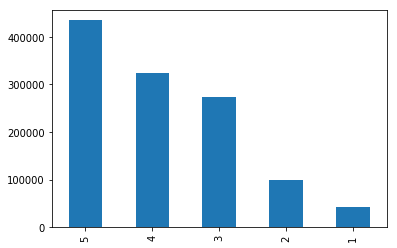

In [41]:
df.Prediction.value_counts().plot.bar()

## Création des datasets pour train and test

In [42]:
df_fifth, test = train_test_split(df, test_size=0.8, random_state=1)
df_hundredth,test = train_test_split(df, test_size=0.99, random_state=1)

In [43]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df[["user","item","Prediction"]], reader)
data_fifth = Dataset.load_from_df(df_fifth[["user","item","Prediction"]], reader)
data_hundredth = Dataset.load_from_df(df_hundredth[["user","item","Prediction"]], reader)

In [44]:
del df_fifth, df_hundredth #freeing memory

## Training de chaque algo

### SVD

In [11]:
algo = SVD(n_factors=5, n_epochs=5000, lr_all=0.004, reg_all=0.07)


In [16]:
model_selection.cross_validate(algo, data, measures=["rmse"], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9876  0.9865  0.9895  0.9905  0.9864  0.9881  0.0016  
Fit time          3466.70 3371.59 5607.17 3279.37 3339.04 3812.77 899.24  
Test time         2.92    2.79    9.81    2.90    3.63    4.41    2.72    


{'test_rmse': array([0.98762085, 0.98654267, 0.98952682, 0.99052904, 0.98638749]),
 'fit_time': (3466.6992824077606,
  3371.5889732837677,
  5607.16778421402,
  3279.369137763977,
  3339.041560649872),
 'test_time': (2.92053484916687,
  2.7905020713806152,
  9.811296463012695,
  2.896577835083008,
  3.6344358921051025)}

In [13]:
algo.fit(data.build_full_trainset())

In [14]:
dump.dump("dump/dump_SVD", algo=algo, verbose=True)

The dump has been saved as file dump/dump_SVD


# param_grid = {
    'n_factors' : [5, 10],
    'n_epochs': [20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.03]
} 
cv=5
algorithm = SVD

gs = model_selection.GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=cv, n_jobs=-5, joblib_verbose=10)  #enlever mae car non utilisé dans le projet pour sauver du temps
gs.fit(data) #checker quelle data est utilisée a chaque algo
print(gs.best_params)
print(gs.best_score)
algo = gs.best_estimator["rmse"]
algo.fit(data.build_full_trainset())
dump.dump("dump/SVDfitted_dump", algo=algo, verbose=1)

### KNN

In [8]:
param_grid = {
    'k' : [10, 40, 100],
    'min_k': [1, 3, 5]
} 
cv=5
algorithm = KNNBasic

gs = model_selection.GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=cv, n_jobs=-7, joblib_verbose=10)  #enlever mae car non utilisé dans le projet pour sauver du temps
gs.fit(data)
print(gs.best_params)
print(gs.best_score)
algo = gs.best_estimator["rmse"]
algo.fit(data.build_full_trainset())
dump.dump("dump/KNN_basic_fitted_dump", algo=algo, verbose=1)

[Parallel(n_jobs=-7)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-7)]: Done   1 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-7)]: Done   4 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-7)]: Done   9 tasks      | elapsed: 29.5min


KeyboardInterrupt: 

### NFM

In [ ]:
param_grid = {
    'n_factors' : [15, 50],
    'n_epochs': [10, 50]
} 
cv=5
algorithm = NMF

gs = model_selection.GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=cv, n_jobs=-5, joblib_verbose=10)  #enlever mae car non utilisé dans le projet pour sauver du temps
gs.fit(data)
print(gs.best_params)
print(gs.best_score)
algo = gs.best_estimator["rmse"]
algo.fit(data.build_full_trainset())
dump.dump("dump/NMFfitted_dump", algo=algo, verbose=1)

### SlopeOne

In [52]:
algo = SlopeOne()
algo.fit(data.build_full_trainset())
dump.dump("dump/SlopeOne_fitted_dump", algo=algo, verbose=1)

FileNotFoundError: [Errno 2] No such file or directory: 'dump/SlopeOne_fitted_dump'

### CoClustering

In [ ]:
param_grid = {
    'n_cltr_u' : [3, 5],
    'n_cltr_i' : [3, 5], 
    'n_epochs': [50, 100]
} 
cv=5
algorithm = CoClustering

gs = model_selection.GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=cv, n_jobs=-5, joblib_verbose=10)  #enlever mae car non utilisé dans le projet pour sauver du temps
gs.fit(data)
print(gs.best_params)
print(gs.best_score)
algo = gs.best_estimator["rmse"]
algo.fit(data.build_full_trainset())
dump.dump("dump/CoClustering_fitted_dump", algo=algo, verbose=1)

## Loading des pickles

In [ ]:
del algo, gs

In [ ]:
array_SVD = np.ones((df2.shape[0],1))
array_KNN = np.ones((df2.shape[0],1))
array_NMF = np.ones((df2.shape[0],1))
array_SlopeOne = np.ones((df2.shape[0],1))
array_CoClustering = np.ones((df2.shape[0],1))

In [ ]:
_, algo_svd = dump.load("dump/SVDfitted_dump")
_, algo_knn = dump.load("dump/KNN_basic_fitted_dump")
_, algo_nmf = dump.load("dump/NMFfitted_dump")
_, algo_slopeone = dump.load("dump/SlopeOne_fitted_dump")
_, algo_coclustering = dump.load("dump/CoClustering_fitted_dump")

## Estimations

In [57]:
valid_items=df.item.unique()
valid_users=df.user.unique()
global_mean=df["Prediction"].mean()
count_bad_users=0
count_bad_items=0
count_bad_both=0
global_mean=df["Prediction"].mean()

for i in df2.iterrows():
    if i[0]%100000==0:
        print(i[0])
    if (i[1]["user"] in valid_users and i[1]["item"] in valid_items):
        array_SVD[i[0]] = algo_svd.estimate(int(i[1][2])-1, int(i[1][3])-1)
        array_KNN[i[0]]= algo_knn.estimate(int(i[1][2])-1, int(i[1][3])-1)[0]
        array_NMF[i[0]] = algo_nmf.estimate(int(i[1][2])-1, int(i[1][3])-1)
        array_SlopeOne[i[0]]=algo_SlopeOne.estimate(int(i[1][2])-1, int(i[1][3])-1)
        array_CoClustering[i[0]] = algo_coclustering.estimate(int(i[1][2])-1, int(i[1][3])-1)
    elif (i[1]["user"] in valid_users):
        user_mean=df[df["user"]==i[1]["user"]].mean()
        array_SVD[i[0]] = user_mean
        array_KNN[i[0]]= user_mean
        array_NMF[i[0]] = user_mean
        array_SlopeOne[i[0]]=user_mean
        array_CoClustering[i[0]] = user_mean
        count_bad_users+=1
    elif (i[1]["item"] in valid_items):
        item_mean=df[df["item"]==i[1]["item"]].mean()
        array_SVD[i[0]] = item_mean
        array_KNN[i[0]]= item_mean
        array_NMF[i[0]] = item_mean
        array_SlopeOne[i[0]]= item_mean
        array_CoClustering[i[0]] = item_mean
        count_bad_items+=1
    else:
        array_SVD[i[0]] = global_mean
        array_KNN[i[0]]= global_mean
        array_NMF[i[0]] = global_mean
        array_SlopeOne[i[0]]= global_mean
        array_CoClustering[i[0]] = global_mean
        count_bad_both+=1
print(f"Done with {count_bad_users} bad users, {count_bad_items} bad items, {count_bad_both} bad both.")

0
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bug
bu

KeyboardInterrupt: 

### Traitement des valeurs non estimées

In [ ]:
'''Here we treat the value of -1000'''
'''
mean_svd = np.mean(array_SVD[array_SVD != -1000])
array_SVD[array_SVD==-1000] = mean_svd

mean_knn = np.mean(array_KNN[array_KNN != -1000])
array_KNN[array_KNN==-1000] = mean_knn

mean_nmf = np.mean(array_NMF[array_NMF != -1000])
array_NMF[array_NMF==-1000] = mean_nmf

mean_slopeone = np.mean(array_SlopeOne[array_SlopeOne != -1000])
array_SlopeOne[array_SlopeOne==-1000] = mean_slopeone

mean_coclustering = np.mean(array_CoClustering[array_CoClustering != -1000])
array_CoClustering[array_CoClustering==-1000] = mean_coclustering
'''

#apparement plus d'erreur en faisant les -1 la cell d'avant

### Blending 

In [ ]:
'''
Full blending to do
Either by 
-using some model like linear regression
-ponderation
-something else, can be worked in the blending branch

results in final_array
'''

#here we blend simply by taking the mean of all models
tmp = np.concatenate((array_SVD, array_KNN, array_NMF, array_SlopeOne, array_CoClustering), axis=1 )
final_array = np.mean(tmp, axis=1)
final_array[final_array>5]=5
final_array[final_array<1]=1
final_array

## Transformation en submission

In [ ]:
df2.Prediction = final_array

In [ ]:
df2 = df2.drop(columns=["user", "item"])

In [ ]:
df2.to_csv("Datasets/submission_pipeline.csv", index=False)